# Set-up

## Imports

In [1]:
import sys
import os
sys.path.append(os.path.abspath('..')) # in order to import from python files not in the same dir

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from tqdm import tqdm
from utils import normalize_curves, functional_norm, initialize_C
from PenNMF_iter import initialize_C_gaussian_prior
from scipy.linalg import block_diag
from sklearn.decomposition import NMF

# HOTFIX Parse IMCEI
import locale
locale.setlocale(locale.LC_ALL, 'it_IT')

%load_ext autoreload
%autoreload 1

%aimport PenNMF
%aimport utils
from utils import plot_components, month_to_season
from PenNMF import PenNMF, _loss_nmf, _loss_constraint_c, _loss_constraint_s

import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio

In [2]:
sns.set_theme()
pd.options.mode.chained_assignment = None

## Parameters

In [3]:
specific = '_Italy'
train_years = ['2021']
test_years = ['2022', '2023']

## Functions

# Create data matrix $X$

In [4]:
infile = f'../data/2_processed/daily_curves{specific}.csv'
# infile = 'data/2_processed/daily_curves_Italy_smoothed_15min.csv'
input_df = pd.read_csv(infile, index_col=0)
# Convert everything in GWh
input_df = input_df / 1000
print(len(input_df))
input_df.head(3)

2191


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Italy_2018-01-01_Holiday,24.743000,23.797000,22.175999,21.042000,20.146999,20.079000,20.942001,21.712000,21.969999,22.967000,...,26.643000,26.807000,29.947001,31.103000,31.537000,30.804001,29.621000,27.749000,25.388000,22.714001
Italy_2018-01-02_Working day,22.714001,20.794001,19.802002,19.573002,19.679000,20.891000,24.197999,28.537000,32.988000,37.794999,...,36.511999,37.393000,41.395000,42.362001,42.081001,39.555000,37.163000,33.313000,29.811000,26.314001
Italy_2018-01-03_Working day,26.314001,24.248999,22.927999,22.537999,22.314001,23.529001,27.206000,32.970999,37.419000,40.908999,...,40.106999,40.662001,44.557000,44.708000,43.818999,41.347000,38.572999,34.229001,30.436999,27.199000


In [5]:
unit_info = input_df.index.str.extract(r'^(?P<region>[\w.]+)_(?P<year>\d{4})-(?P<month>\d{2})-\d{2}_(?P<daytype>[\w ]+)$').set_index(input_df.index)
h = 24 / (input_df.shape[1]-1)
unit_info['cons'] = input_df.apply(lambda row: functional_norm(row.values, h), axis=1)
df = pd.concat([input_df, unit_info], axis=1)
# Drop years for which we don't have indicators
df = df[df.year.astype(int) > 2019]
df_train = df[df.year.isin(train_years)]
df_test = df[df.year.isin(test_years)]
print(len(df))
df.head(3)

1461


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,region,year,month,daytype,cons
Italy_2020-01-01_Holiday,24.300000,23.308000,22.157999,20.786000,19.891000,19.947001,20.578999,21.473999,21.413001,22.792,...,30.347000,29.180,27.406000,24.879000,22.212999,Italy,2020,01,Holiday,592.946498
Italy_2020-01-02_Working day,22.212999,20.395000,19.276000,19.059001,19.167999,20.177000,23.560000,28.026999,31.600000,35.583,...,38.273000,35.756,32.371000,28.863001,25.324000,Italy,2020,01,Working day,744.497504
Italy_2020-01-03_Working day,25.324000,23.275001,21.741000,21.228999,21.438000,22.064999,25.270000,30.257000,34.130000,37.619,...,38.369999,35.184,31.951999,28.347001,25.134999,Italy,2020,01,Working day,778.622499


In [6]:
X_train = df_train.drop(unit_info.columns, axis=1)
X_test = df_test.drop(unit_info.columns, axis=1)
X_train = normalize_curves(X_train)
X_test = normalize_curves(X_test)
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Italy_2021-01-01_Holiday,0.040804,0.038742,0.035854,0.033708,0.032238,0.032600,0.034120,0.035383,0.035496,0.038184,...,0.042573,0.043251,0.047590,0.048918,0.050168,0.050272,0.048012,0.045464,0.041705,0.038179
Italy_2021-01-02_Saturday,0.034414,0.031907,0.030306,0.029319,0.029488,0.030321,0.033353,0.036153,0.038945,0.042298,...,0.044727,0.045919,0.050289,0.052199,0.053566,0.051826,0.048080,0.044351,0.039698,0.035197
Italy_2021-01-03_Holiday,0.037353,0.034144,0.032665,0.031295,0.030793,0.031833,0.033681,0.035499,0.037216,0.040036,...,0.043765,0.044670,0.049144,0.051261,0.052497,0.052119,0.048489,0.045250,0.041502,0.037208
Italy_2021-01-04_Monday,0.029707,0.027360,0.026213,0.026345,0.026738,0.027907,0.031743,0.037142,0.042662,0.047633,...,0.049228,0.049020,0.052170,0.052683,0.052748,0.049429,0.045780,0.041584,0.037839,0.033934
Italy_2021-01-05_Working day,0.032900,0.030340,0.028683,0.028162,0.028115,0.029145,0.032760,0.038128,0.043562,0.047061,...,0.048094,0.048353,0.051152,0.051067,0.050467,0.048227,0.044795,0.041040,0.036631,0.032362


In [7]:
X_test.to_pickle('../data/2_processed/PenNMF/X_{}.pkl'.format('_'.join(test_years)))

In [8]:
cons_df = pd.read_excel('../data/1_input/consumption/consumption.xlsx', index_col=0)
cons_df['Industria'] = cons_df['Industria'] + cons_df['Agricoltura'] # We put agricoltura sector in the industrial one
cons_df.drop('Agricoltura', axis=1, inplace=True)

# Add 2023: CAUTION, they are only estimates
cons_2023 = pd.read_excel('../data/1_input/consumption/Stima consumi annuario 2023.xlsx', skiprows=1, index_col=0, usecols=[1,2]).drop('Totale')
cons_2023.index = cons_2023.index.str.replace('AGRICOLTURA', 'INDUSTRIA').str.capitalize().str.strip() # We put agricoltura sector in the industrial one
cons_2023 = cons_2023.groupby(cons_2023.index).sum()

cons_df.loc[2023, :] = cons_2023['2023 Annuario']

# Align with the consumption computed from the load data
uncorrected_total = cons_df[['Servizi', 'Industria', 'Domestico']].sum(axis=1).values
corrected_total = df.groupby('year')['cons'].sum().values
cons_df = cons_df.mul(corrected_total / uncorrected_total, axis=0)
cons_df

,Domestico,Industria,Servizi
Year,,,
2020,70346.781377,139954.732220,91238.239988
2021,70928.897300,150696.258135,96657.697020
2022,68793.289167,145668.191390,100961.844908
2023,67161.924142,140246.809266,100516.753981


# Create indicators matrix $\mathrm{Y}$

In [28]:
imser = pd.read_excel('../data/1_input/indicators/IMSER2.xlsx')
imser = imser.set_index('Mese').rename({'IMSER (GWh)': 'IMSER'}, axis=1) # We don't have data for this year

imcei = pd.read_excel('../data/1_input/indicators/IMCEI_mensile.xlsx')
imcei['Mese'] = pd.to_datetime(imcei['Anno'].astype(str) + '-' + imcei['Mese'], format='%Y-%b')
imcei = imcei.set_index('Mese').drop('Anno', axis=1).rename({'IMCEI Mensile': 'IMCEI'}, axis=1)

domestic1 = pd.read_excel('../data/1_input/indicators/Domestico 2020 e 2021.xlsx', skiprows=12, usecols=range(3))
domestic2 = pd.read_excel('../data/1_input/indicators/Domestico 2022 e 2023.xlsx', skiprows=12, usecols=range(3))
domestic = pd.concat([domestic1, domestic2], ignore_index=True)
domestic = domestic.set_index('Mese').drop('Domestico kWh', axis=1)

indics = imcei.copy()
indics['IMSER'] = imser['IMSER']
indics['EnelDom'] = domestic['Domestico GWh']
indics = indics[indics.index >= "2020-01-01"]
indics.head()

,IMCEI,IMSER,EnelDom
Mese,,,
2020-01-01,95.501727,6767.710901,4741.474351
2020-02-01,102.158558,6108.615709,4120.931091
2020-03-01,83.918607,5072.078974,4571.397146
2020-04-01,67.621478,4106.738593,4056.375574
2020-05-01,98.087167,4941.189899,3817.225967


In [29]:
indics.to_csv('../data/indicators/indicators.csv')

In [10]:
# Create train and test set
indics_train = indics[indics.index.year.astype(str).isin(train_years)]
indics_test = indics[indics.index.year.astype(str).isin(test_years)]

In [11]:
cons_df

,Domestico,Industria,Servizi
Year,,,
2020,70346.781377,139954.732220,91238.239988
2021,70928.897300,150696.258135,96657.697020
2022,68793.289167,145668.191390,100961.844908
2023,67161.924142,140246.809266,100516.753981


In [12]:
indics.rename(columns={'IMSER': 'Servizi', 'IMCEI': 'Industria', 'EnelDom': 'Domestico'}, inplace=True)
indics['year'] = indics.index.year
indic_totals = indics[['year']].merge(indics.groupby('year').sum(), left_on='year', right_index=True, how='left').drop('year', axis=1)
cons_rescaling = indics[['year']].merge(cons_df, left_on='year', right_index=True, how='left').drop('year', axis=1)
indics.drop('year', axis=1, inplace=True)
Y = indics.div(indic_totals).mul(cons_rescaling)
# Realign with load data at month level (since it is not guaranteed anymore at the month level after the breakdown along months)
uncorrected_total = Y[['Domestico', 'Industria', 'Servizi']].sum(axis=1).values
corrected_total = df.groupby(['year', 'month'])['cons'].sum().values
Y = Y.mul(corrected_total / uncorrected_total, axis=0)
Y

,Domestico,Industria,Servizi
Mese,,,
2020-01-01,6578.069013,12076.214575,8758.839428
2020-02-01,5527.985114,12490.529300,7644.235592
2020-03-01,6397.951558,10704.954781,6622.130700
2020-04-01,5700.031442,8660.806370,5383.390680
2020-05-01,4977.937414,11658.651789,6011.084788
2020-06-01,4910.926859,11869.539002,7233.085663
2020-07-01,6107.741032,13094.183037,9521.393403
2020-08-01,7009.210582,8879.384386,9913.436574
2020-09-01,5157.447797,12777.718546,8433.093670


In [13]:
Y_train = Y[Y.index.year.astype(str).isin(train_years)]
Y_test = Y[Y.index.year.astype(str).isin(test_years)]

In [14]:
Y_train.to_pickle('../data/2_processed/PenNMF/Y_{}.pkl'.format('_'.join(train_years)))
Y_test.to_pickle('../data/2_processed/PenNMF/Y_{}.pkl'.format('_'.join(test_years)))
Y.to_pickle('../data/2_processed/PenNMF/Y.pkl')

# Create parameter matices $\mathrm{B}$ and $\mathrm{A}$

In [15]:
X_train_unnorm = df_train.drop(unit_info.columns, axis=1)
h = 24 / (X_train_unnorm.shape[1]-1)
norm_X = X_train_unnorm.apply(lambda row: functional_norm(row, h), axis=1, raw=True)
norm_X = pd.DataFrame(norm_X, index=norm_X.index, columns=['norm_X'])
norm_X['month'] = norm_X.index.str[6:13]
norm_X

,norm_X,month
Italy_2021-01-01_Holiday,597.368996,2021-01
Italy_2021-01-02_Saturday,662.733499,2021-01
Italy_2021-01-03_Holiday,624.469497,2021-01
Italy_2021-01-04_Monday,782.132998,2021-01
Italy_2021-01-05_Working day,806.720001,2021-01
...,...,...
Italy_2021-12-27_Monday,761.557999,2021-12
Italy_2021-12-28_Working day,785.860998,2021-12
Italy_2021-12-29_Working day,761.050505,2021-12
Italy_2021-12-30_Working day,773.259500,2021-12


In [16]:
m = norm_X.index.str[6:13].nunique() # n_months
n = len(X_train) # n_days
blocks = [norm_X.loc[norm_X.month == month, 'norm_X'].values[np.newaxis, :] for month in norm_X.index.str[6:13].unique()]
B = block_diag(*blocks)
B.shape

(12, 365)

In [17]:
B = pd.DataFrame(B, index=Y_train.index, columns=norm_X.index)
B

,Italy_2021-01-01_Holiday,Italy_2021-01-02_Saturday,Italy_2021-01-03_Holiday,Italy_2021-01-04_Monday,Italy_2021-01-05_Working day,Italy_2021-01-06_Holiday,Italy_2021-01-07_Working day,Italy_2021-01-08_Working day,Italy_2021-01-09_Saturday,Italy_2021-01-10_Holiday,...,Italy_2021-12-22_Working day,Italy_2021-12-23_Working day,Italy_2021-12-24_Working day,Italy_2021-12-25_Holiday,Italy_2021-12-26_Holiday,Italy_2021-12-27_Monday,Italy_2021-12-28_Working day,Italy_2021-12-29_Working day,Italy_2021-12-30_Working day,Italy_2021-12-31_Working day
Mese,,,,,,,,,,,,,,,,,,,,,
2021-01-01,597.368996,662.733499,624.469497,782.132998,806.720001,693.469,914.726001,935.038998,791.720002,705.723499,...,0.00000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
2021-02-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
2021-03-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
2021-04-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
2021-05-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
2021-06-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
2021-07-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
2021-08-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
2021-09-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000


In [18]:
with open('../data/2_processed/PenNMF/B_{}.pkl'.format('_'.join(train_years)), 'wb') as file:
    pickle.dump(B, file)

In [19]:
A = np.array([
    [1, 0, 0],
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1],
    [0, 0, 1]
])

# A = np.array([
#     [1, 0, 0],
#     [0, 1, 0],
#     [0, 0, 1]
# ])

# A = np.array([
#     [1, 0, 0],
#     [1, 0, 0],
#     [0, 1, 0],
#     [0, 1, 0],
#     [0, 0, 1],
#     [0, 0, 1]
# ])

A.shape

(5, 3)

# Initialize matrix $C$

In [20]:
month_cons = pd.Series([a.sum() for a in blocks], index=Y_train.index)
month_cons

Mese
2021-01-01    27083.284488
2021-02-01    24824.543014
2021-03-01    26463.659500
2021-04-01    23956.100005
2021-05-01    24404.707491
2021-06-01    27204.256011
2021-07-01    30413.022475
2021-08-01    26660.941487
2021-09-01    27000.608978
2021-10-01    26363.029513
2021-11-01    26495.148006
2021-12-01    27413.551487
dtype: float64

In [21]:
concentrations_unnorm = Y_train.div(month_cons, axis=0) # type: ignore
concentrations = concentrations_unnorm.div(concentrations_unnorm.sum(axis=1), axis=0)
concentrations

,Domestico,Industria,Servizi
Mese,,,
2021-01-01,0.263679,0.440113,0.296208
2021-02-01,0.232126,0.481513,0.286362
2021-03-01,0.226285,0.502267,0.271448
2021-04-01,0.221531,0.511776,0.266693
2021-05-01,0.196245,0.524060,0.279695
2021-06-01,0.197728,0.484058,0.318214
2021-07-01,0.211910,0.456102,0.331988
2021-08-01,0.265953,0.356040,0.378007
2021-09-01,0.188232,0.503458,0.308310


In [22]:
C_init_mean = pd.DataFrame(index=X_train.index)
C_init_mean['month'] = pd.to_datetime(C_init_mean.index.str[6:16])
C_init_mean['month'] = C_init_mean['month'].apply(lambda d: d.replace(day=1))
for g in range(A.shape[1]):
    sources_g = np.nonzero(A[:, g])[0]
    for s in sources_g:
        C_init_mean.loc[:, f"Component {s+1}"] = C_init_mean.merge(concentrations, left_on='month', right_index=True)[concentrations.columns[g]] / len(sources_g)
C_init_mean.drop('month', axis=1, inplace=True)
C_init_mean

,Component 1,Component 2,Component 3,Component 4,Component 5
Italy_2021-01-01_Holiday,0.131839,0.131839,0.440113,0.148104,0.148104
Italy_2021-01-02_Saturday,0.131839,0.131839,0.440113,0.148104,0.148104
Italy_2021-01-03_Holiday,0.131839,0.131839,0.440113,0.148104,0.148104
Italy_2021-01-04_Monday,0.131839,0.131839,0.440113,0.148104,0.148104
Italy_2021-01-05_Working day,0.131839,0.131839,0.440113,0.148104,0.148104
...,...,...,...,...,...
Italy_2021-12-27_Monday,0.130211,0.130211,0.420648,0.159465,0.159465
Italy_2021-12-28_Working day,0.130211,0.130211,0.420648,0.159465,0.159465
Italy_2021-12-29_Working day,0.130211,0.130211,0.420648,0.159465,0.159465
Italy_2021-12-30_Working day,0.130211,0.130211,0.420648,0.159465,0.159465


In [23]:
# with open('data/2_processed/PenNMF/C_init_mean.pkl', 'wb') as file:
#     pickle.dump(C_init_mean, file)

# PenNMF

In [23]:
n = len(X_train)
p = len(X_train.columns)
# n_components = len(C_init_mean.columns)
n_components = A.shape[0]

C_init = initialize_C(X_train, n_components)
# C_init = initialize_C_gaussian_prior(C_init_mean)
S_init = normalize_curves(np.ones((n_components, p)))

## Specify $\mathrm{E}$, $\mathrm{D}$ and $\mathrm{Y}$ matrices for constraints on $S$

In [24]:
E = np.eye(n_components)
Z = np.ones((n_components, 1))

# Creating matrix D is a little more complicated as the multiplication of each row of S with the column matrix D should give the functional norm
# The lines below essentially consist in writing the functional_norm as a vectorized function
D = np.ones((p, 1))
D[0, 0] = 0.5
D[-1, 0] = 0.5
h = 24 / (p-1)
D = h * D

In [25]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Italy_2021-01-01_Holiday,0.040804,0.038742,0.035854,0.033708,0.032238,0.032600,0.034120,0.035383,0.035496,0.038184,...,0.042573,0.043251,0.047590,0.048918,0.050168,0.050272,0.048012,0.045464,0.041705,0.038179
Italy_2021-01-02_Saturday,0.034414,0.031907,0.030306,0.029319,0.029488,0.030321,0.033353,0.036153,0.038945,0.042298,...,0.044727,0.045919,0.050289,0.052199,0.053566,0.051826,0.048080,0.044351,0.039698,0.035197
Italy_2021-01-03_Holiday,0.037353,0.034144,0.032665,0.031295,0.030793,0.031833,0.033681,0.035499,0.037216,0.040036,...,0.043765,0.044670,0.049144,0.051261,0.052497,0.052119,0.048489,0.045250,0.041502,0.037208
Italy_2021-01-04_Monday,0.029707,0.027360,0.026213,0.026345,0.026738,0.027907,0.031743,0.037142,0.042662,0.047633,...,0.049228,0.049020,0.052170,0.052683,0.052748,0.049429,0.045780,0.041584,0.037839,0.033934
Italy_2021-01-05_Working day,0.032900,0.030340,0.028683,0.028162,0.028115,0.029145,0.032760,0.038128,0.043562,0.047061,...,0.048094,0.048353,0.051152,0.051067,0.050467,0.048227,0.044795,0.041040,0.036631,0.032362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Italy_2021-12-27_Monday,0.029975,0.027723,0.026592,0.026091,0.026118,0.027452,0.031685,0.037448,0.043143,0.048461,...,0.048881,0.049225,0.052037,0.051697,0.051548,0.049241,0.045457,0.041209,0.036914,0.033171
Italy_2021-12-28_Working day,0.032146,0.029966,0.028617,0.027832,0.027936,0.029168,0.032588,0.038372,0.044393,0.048580,...,0.048194,0.048028,0.051152,0.050903,0.050659,0.048150,0.044725,0.040248,0.035849,0.032087
Italy_2021-12-29_Working day,0.033133,0.030512,0.029107,0.028394,0.028430,0.029614,0.033534,0.039242,0.044130,0.048258,...,0.046530,0.046826,0.050618,0.051014,0.050771,0.048555,0.044809,0.040779,0.036631,0.033702
Italy_2021-12-30_Working day,0.033170,0.030422,0.029202,0.028728,0.028826,0.030280,0.034086,0.039912,0.044722,0.048465,...,0.046354,0.046402,0.049787,0.050471,0.050767,0.048828,0.045276,0.041357,0.036980,0.033696


## Find suitable $\alpha$ and $\beta$ regularisation parameters

In [26]:
loss_nmf = _loss_nmf(X_train, C_init, S_init)
loss_constraint_c = _loss_constraint_c(Y_train, B.values, C_init, A)
loss_constraint_s = _loss_constraint_s(Z, E, S_init, D)

print(loss_nmf, loss_constraint_c, loss_constraint_s)
print(loss_nmf / loss_constraint_c)

0.46865517476248736 1007063175.1878599 1.232595164407831e-32
4.6536819765558735e-10


In [27]:
# The term that beta controls is the sum of n_component deviations from the unit-functional-normed vector, so we can safely set it to 1 or 0.1
beta = 1

In [40]:
### Search for alphas ###

n_alphas = 20
pow_min = -11
pow_max = -8
alphas = 10 ** np.linspace(pow_min, pow_max, n_alphas)
# alphas = np.linspace(1e-10, 1e-9, n_alphas) # for uniform initilisation 5 components
# alphas = np.linspace(5e-10, 5e-9, n_alphas) # for uniform initilisation 3 components
# alphas = np.linspace(5e-8, 5e-7, n_alphas) # for gaussian initialisation
n_runs = 10

n_iter_df = pd.DataFrame(columns=alphas, index=range(n_runs))
loss_nmf_df = pd.DataFrame(columns=alphas, index=range(n_runs))
loss_constraint_c_df = pd.DataFrame(columns=alphas, index=range(n_runs))
loss_constraint_s_df = pd.DataFrame(columns=alphas, index=range(n_runs))

for alpha in tqdm(alphas):
    n_iter = []
    loss_nmf = []
    loss_constraint_c = []
    loss_constraint_s = []

    model = PenNMF(
        n_components=n_components,
        alpha=alpha,
        beta=beta
    )

    for runs in range(n_runs):
        C_init = initialize_C(X_train, n_components)
        # C_init = initialize_C_gaussian_prior(C_init_mean)
        C = model.fit_transform(X_train.values, C_init.values, S_init, Y_train.values, A, B.values, Z, D, E)

        n_iter.append(model.n_iter_)
        loss_nmf.append(model.losses_nmf_[-1])
        loss_constraint_c.append(model.losses_constraint_c_[-1])
        loss_constraint_s.append(model.losses_constraint_s_[-1])
    
    n_iter_df[alpha] = n_iter
    loss_nmf_df[alpha] = loss_nmf
    loss_constraint_c_df[alpha] = loss_constraint_c
    loss_constraint_s_df[alpha] = loss_constraint_s
    


100%|██████████| 20/20 [01:21<00:00,  4.08s/it]


<Axes: >

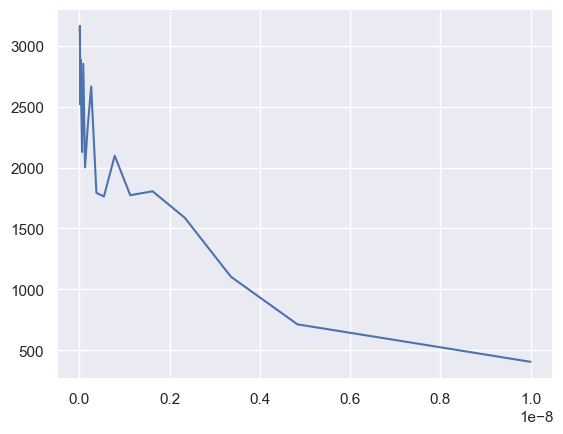

In [41]:
n_iter_df.mean(axis=0).plot()

<Axes: >

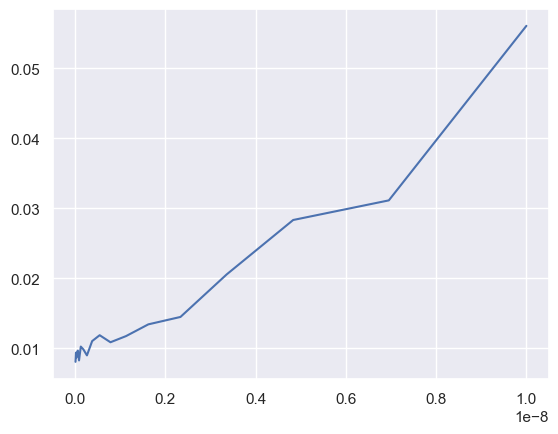

In [42]:
loss_nmf_df.mean(axis=0).plot()

<Axes: >

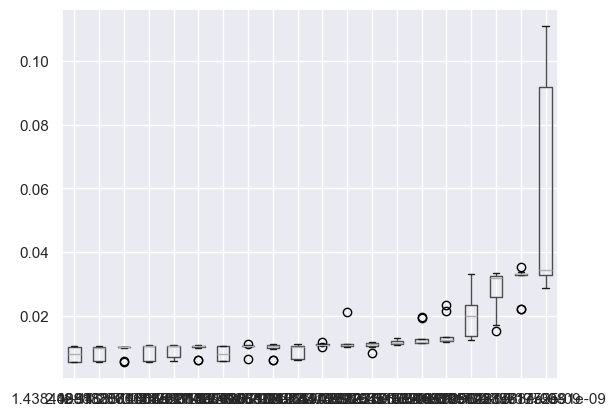

In [43]:
loss_nmf_df.boxplot()

In [44]:
loss_nmf_df.median(axis=0)

1.000000e-11    0.008065
1.438450e-11    0.010003
2.069138e-11    0.010197
2.976351e-11    0.010547
4.281332e-11    0.010545
6.158482e-11    0.010521
8.858668e-11    0.008160
1.274275e-10    0.010569
1.832981e-10    0.010736
2.636651e-10    0.010334
3.792690e-10    0.010954
5.455595e-10    0.010954
7.847600e-10    0.011129
1.128838e-09    0.011395
1.623777e-09    0.011860
2.335721e-09    0.012431
3.359818e-09    0.020083
4.832930e-09    0.032034
6.951928e-09    0.033039
1.000000e-08    0.034276
dtype: float64

In [45]:
loss_nmf_df

,1.000000e-11,1.438450e-11,2.069138e-11,2.976351e-11,4.281332e-11,6.158482e-11,8.858668e-11,1.274275e-10,1.832981e-10,2.636651e-10,3.792690e-10,5.455595e-10,7.847600e-10,1.128838e-09,1.623777e-09,2.335721e-09,3.359818e-09,4.832930e-09,6.951928e-09,1.000000e-08
0,0.010482,0.005930,0.010118,0.010517,0.010423,0.010427,0.006039,0.010548,0.010670,0.010385,0.011301,0.010979,0.011228,0.011088,0.011477,0.012216,0.022584,0.033054,0.035213,0.032610
1,0.010387,0.010605,0.010300,0.005837,0.010534,0.010657,0.010663,0.010671,0.011137,0.006531,0.011034,0.010319,0.010550,0.011270,0.019529,0.012086,0.013789,0.032299,0.022045,0.034686
2,0.005575,0.010264,0.010301,0.010658,0.010556,0.010105,0.006333,0.010514,0.011152,0.010362,0.010330,0.010521,0.008528,0.012507,0.011604,0.012990,0.013187,0.024103,0.033024,0.033878
3,0.005657,0.005688,0.005986,0.010612,0.010896,0.010386,0.009986,0.010565,0.006193,0.010738,0.010903,0.010615,0.010222,0.011457,0.011639,0.011828,0.032733,0.015221,0.033181,0.028785
4,0.010534,0.010549,0.005623,0.010582,0.010843,0.006058,0.005937,0.010451,0.006181,0.006308,0.010932,0.010929,0.011073,0.011454,0.011689,0.013451,0.012484,0.032153,0.022319,0.034070
5,0.005836,0.005905,0.010150,0.005822,0.005983,0.010758,0.010708,0.011161,0.011029,0.010306,0.011728,0.011111,0.011499,0.011052,0.012030,0.012170,0.020385,0.031558,0.032720,0.110764
6,0.010295,0.005931,0.010183,0.010577,0.006120,0.006172,0.005968,0.010798,0.010635,0.006582,0.011229,0.021128,0.011895,0.013097,0.011672,0.012555,0.013728,0.017021,0.033124,0.029587
7,0.005727,0.010415,0.010431,0.005693,0.006124,0.010616,0.010612,0.006493,0.010989,0.011227,0.010934,0.011074,0.011184,0.012855,0.012334,0.012307,0.033029,0.031915,0.033055,0.110899
8,0.005697,0.010034,0.010407,0.010793,0.010666,0.010741,0.005932,0.010607,0.009712,0.006741,0.010973,0.011153,0.010865,0.011337,0.019220,0.021672,0.019781,0.033434,0.032754,0.034482
9,0.010400,0.009973,0.010211,0.005785,0.010660,0.010706,0.010452,0.010572,0.010803,0.010627,0.010871,0.010784,0.011512,0.011209,0.012924,0.023426,0.023763,0.032409,0.033749,0.110700


<Axes: >

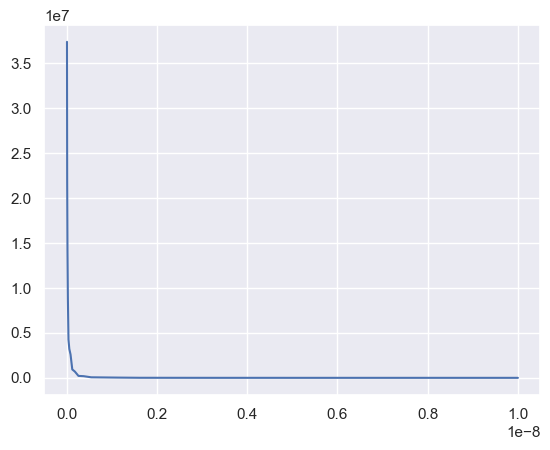

In [46]:
loss_constraint_c_df.mean(axis=0).plot()

<Axes: >

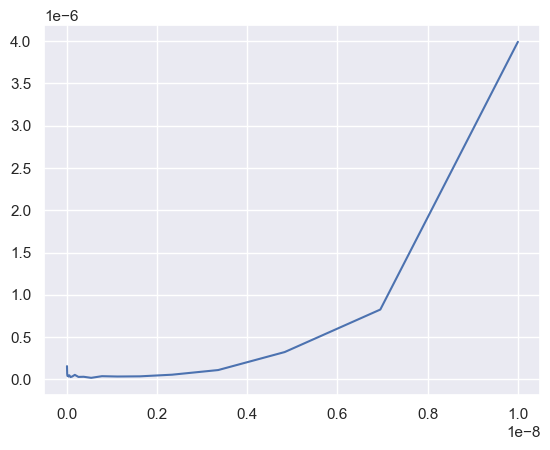

In [47]:
loss_constraint_s_df.mean(axis=0).plot()

Text(0.5, 0, 'alpha')

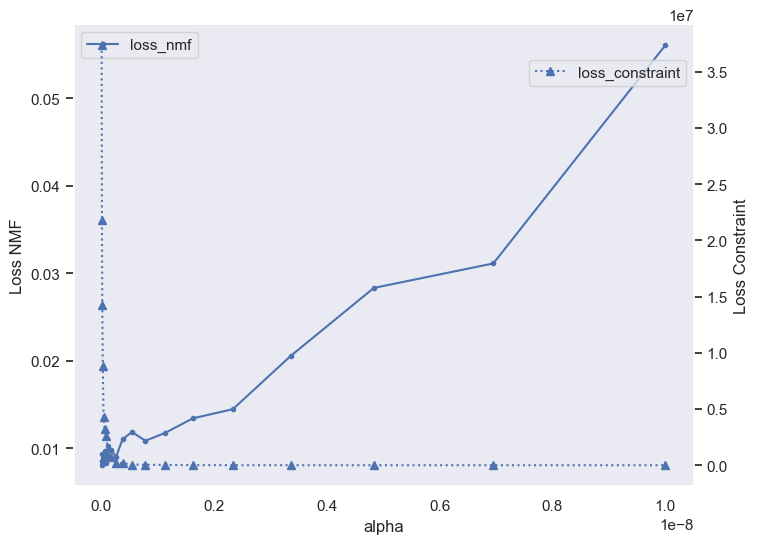

In [48]:
plt.figure(figsize=(8, 6))
ax1 = plt.gca()
loss_nmf_df.mean(axis=0).plot(ax=ax1, label='loss_nmf', marker='.')
ax1.grid(None)
ax1.legend()
ax1.set_ylabel('Loss NMF')

ax2 = ax1.twinx()
loss_constraint_c_df.mean(axis=0).plot(ax=ax2, label='loss_constraint', marker='^', linestyle='dotted')
ax2.grid(None)
ax2.legend(loc='upper right', bbox_to_anchor=(1,0.94))
ax2.set_ylabel('Loss Constraint')
ax1.set_xlabel('alpha')
# plt.xlim((0, 1e-8))

In [49]:
loss_nmf = loss_nmf_df.mean(axis=0).values
loss_constraint_c = loss_constraint_c_df.mean(axis=0).values
loss_constraint_s = loss_constraint_s_df.mean(axis=0).values

# Create the hover text with indices
hover_text_nmf = [f"Index: {i}<br>Alpha: {alpha:.1e}<br>Loss NMF: {loss}" for i, (alpha, loss) in enumerate(zip(alphas, loss_nmf))]
hover_text_constraint_c = [f"Index: {i}<br>Alpha: {alpha:.1e}<br>Loss Constraint C: {loss}" for i, (alpha, loss) in enumerate(zip(alphas, loss_constraint_c))]
hover_text_constraint_s = [f"Index: {i}<br>Alpha: {alpha:.1e}<br>Loss Constraint S: {loss}" for i, (alpha, loss) in enumerate(zip(alphas, loss_constraint_s))]

# Create traces
trace1 = go.Scatter(
    x=alphas,
    y=loss_nmf,
    mode='lines+markers',
    name='Loss NMF',
    marker=dict(symbol='circle'),
    line=dict(shape='linear'),
    hovertemplate=hover_text_nmf
)

trace2 = go.Scatter(
    x=alphas,
    y=loss_constraint_c,
    mode='lines+markers',
    name='Loss Constraint C',
    marker=dict(symbol='triangle-up'),
    line=dict(shape='linear', dash='dot'),
    yaxis='y2',
    hovertemplate=hover_text_constraint_c
)

trace3 = go.Scatter(
    x=alphas,
    y=loss_constraint_s,
    mode='lines+markers',
    name='Loss Constraint S',
    marker=dict(symbol='diamond'),
    line=dict(shape='linear', dash='dot'),
    yaxis='y1',
    hovertemplate=hover_text_constraint_s
)


# Create layout
layout = go.Layout(
    title='Loss vs Alpha',
    xaxis=dict(
        title='Alpha',
        type='log',  # Use logarithmic scale for x-axis
        # range=[-8, -5],  # Adjust range for log scale
        showgrid=False
    ),
    yaxis=dict(
        title='Loss NMF',
    ),
    yaxis2=dict(
        title='Loss Constraint',
        overlaying='y',
        side='right'
    ),
    width=800,
    height=600,
    legend=dict(x=1, y=0.94)
)

# Create figure
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)

# pio.write_html(fig, file='plot.html', auto_open=True)

# Show plot
fig.show()

In [59]:
tol = 1e-5
max_iter = 10000
verbose = 0
alpha = 3e-10
beta = 1

model = PenNMF(
    n_components=n_components,
    alpha=alpha,
    beta=beta,
    tol=tol,
    max_iter=max_iter,
    verbose=0
)

S_init = normalize_curves(np.ones((n_components, p)))
# C_init = initialize_C_gaussian_prior(C_init_mean)
C_init = initialize_C(X_train, n_components)

C = model.fit_transform(X_train.values, C_init.values, S_init, Y_train.values, A, B.values, Z, D, E)

Total loss:  0.006084744886161447

Loss NMF:  0.006011517445359122
Loss constraint:  244091.46934108317


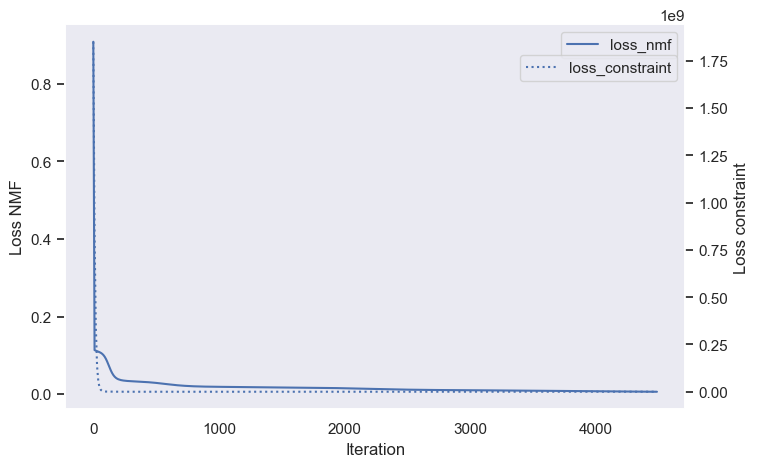

In [60]:
n_iter = model.n_iter_
losses_nmf = model.losses_nmf_
losses_constraint = model.losses_constraint_c_
# losses_constraint_s = model.losses_constraint_s_

plt.figure(figsize=(8, 5))
ax1 = plt.gca()
ax1.plot(np.arange(0, n_iter + 1, 10), losses_nmf, label='loss_nmf')
ax1.grid(None)
ax1.legend()

ax2 = ax1.twinx()
ax2.plot(np.arange(0, n_iter + 1, 10), losses_constraint, linestyle='dotted', label='loss_constraint')
ax2.grid(None)
ax2.legend(loc='upper right', bbox_to_anchor=(1,0.94))

ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss NMF')
ax2.set_ylabel('Loss constraint')

print("Total loss: ", losses_nmf[-1] + alpha * losses_constraint[-1])
print("\nLoss NMF: ", losses_nmf[-1])
print("Loss constraint: ", losses_constraint[-1])

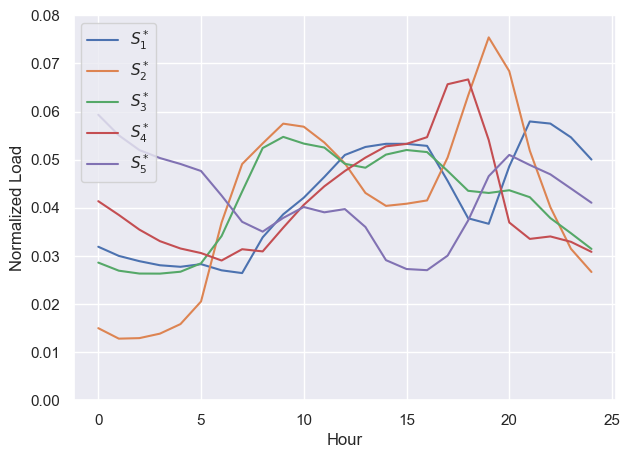

In [61]:
plot_components(model.components_, labels=[f'$S_{i+1}^*$' for i in range(n_components)], marker=None, linewidth=1.5, figsize=(7, 5))
ylim = plt.ylim((0, 0.08))

In [62]:
# Check L^1-norms
model.components_.dot(D)

array([[1.00003584],
       [0.99997921],
       [0.99987297],
       [1.00007333],
       [0.99992395]])

## Compare with NMF

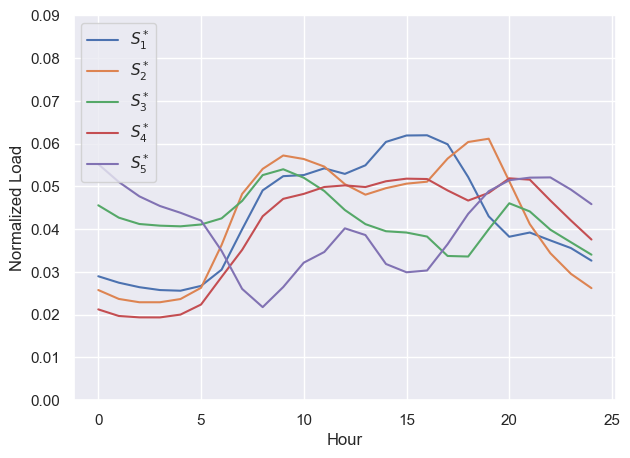

In [63]:
nmf = NMF(
        n_components=n_components,
        solver='mu',
        tol=tol,
        init='custom',
        max_iter=max_iter,
        verbose=verbose
)

C = nmf.fit_transform(
            X_train.values,
            W=C_init.values.copy(order='C'),
            H=S_init
        )

plot_components(nmf.components_, labels=[f'$S_{i+1}^*$' for i in range(n_components)], marker=None, linewidth=1.5, figsize=(7, 5))
ylim = plt.ylim((0, 0.09))

<Axes: >

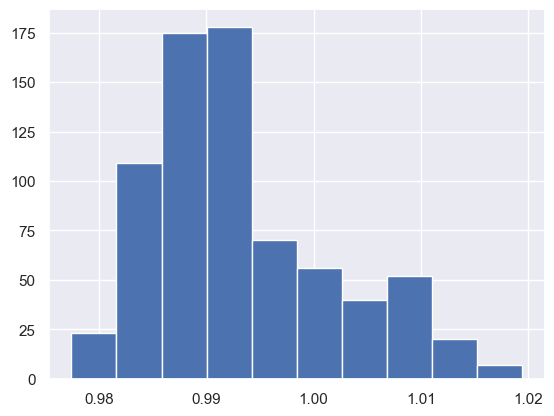

In [64]:
concentrations = pd.DataFrame(C, index=X_train.index)
concentrations.sum(axis=1).hist()

In [65]:
_loss_nmf(X_train, C, nmf.components_)

0.005340939083379167

<HR>

# Tests